<a href="https://colab.research.google.com/github/leoricca02/ML_project/blob/main/Taxi_Environment_DQN_vs_Tabular_Q_Learning_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Taxi-v3 Environment: DQN vs Tabular Q-Learning Comparison**
`Leonardo Ricca 2211129`

---


This notebook implements and compares two reinforcement learning algorithms for the OpenAI Gym Taxi-v3 environment:

**Deep Q-Network (DQN)** - Neural network-based approach

**Tabular Q-Learning** - Traditional table-based approach

Both implementations support stochastic environment variations (rainy weather and fickle passengers).

# **Tabular Q-Learning Implementation**
These are the imports for the Tabular Q-Learning implementation:

*   `gymnasium` for the environment
*   `numpy` for numerical operations
*   `matplotlib`
*   `pyplot` for plotting
*   `pickle` and `os` for saving and loading data

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

### **Environment Variants**

The implementation supports multiple environment configurations:

*  **Deterministic Environment**: Standard Taxi-v3 with predictable dynamics
*  **Rainy Weather**: Movement actions have 80% success rate with 10% drift
*  **Fickle Passenger**: 30% chance passenger changes destination mid-ride

**Adaptive Hyperparameters**

The agent automatically adjusts its learning parameters based on environment complexity:

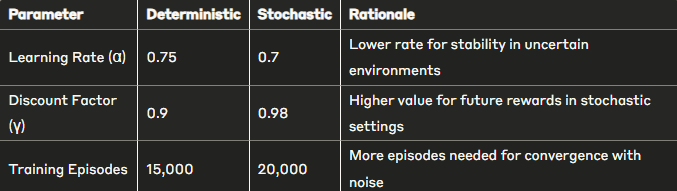

In [ ]:
class TaxiQLearning:
    def __init__(self, is_rainy=False, fickle_passenger=False):

        """
        Initialize Tabular Q-Learning with stochastic environment options

        Args:
            is_rainy (bool): If True, movement actions have 80% success rate,
                             10% chance each of moving left/right of intended direction
            fickle_passenger (bool): If True, passenger has 30% chance of changing
                                   destinations after first movement away from pickup
        """
        self.is_rainy = is_rainy
        self.fickle_passenger = fickle_passenger
        self.is_stochastic = is_rainy or fickle_passenger

        # Adaptive hyperparameters based on environment complexity
        if self.is_stochastic:
            self.learning_rate_a = 0.7           # Slightly lower learning rate for stability
            self.discount_factor_g = 0.98        # Higher discount factor to value future rewards more in a stochastic setting
            self.epsilon_decay_rate = 0.0001
            self.min_learning_rate = 0.05        # Prevent learning rate from dropping too low
            self.default_episodes = 20000        # More episodes for convergence in stochastic environment
        else:
            self.learning_rate_a = 0.75           # Your original values
            self.discount_factor_g = 0.9
            self.epsilon_decay_rate = 0.0001
            self.min_learning_rate = 0.0001
            self.default_episodes = 15000

        self.ACTIONS = ['S', 'N', 'E', 'W', 'P', 'D']

        print(f"Environment: is_rainy={is_rainy}, fickle_passenger={fickle_passenger}")
        print(f"Hyperparameters: α={self.learning_rate_a}, γ={self.discount_factor_g}, "
              f"ε_decay={self.epsilon_decay_rate}, episodes={self.default_episodes}")

## **Training and Testing Pipeline - Part 1: Setup & Initialization**

The `run()` method is the core pipeline that handles both training and testing phases of the Q-Learning agent. This method demonstrates the complete workflow from environment setup to model persistence.

### **Key Setup Components**

**Environment Configuration**

*  Dynamic environment creation with stochastic parameters
*  Render mode selection for visualization during testing
*  Model file naming based on environment type (taxi.pkl vs taxi_stochastic.pkl)

**Q-Table Management**

*  Training: Initialize fresh Q-table (500 states × 6 actions)
*  Testing: Load pre-trained Q-table from saved model
*  Error handling for missing trained models

**Parameter Initialization**

*  Adaptive hyperparameters loaded from class configuration
*  Epsilon-greedy exploration starting at 100% exploration
*  Progress tracking arrays for comprehensive analysis

In [ ]:
def run(self, episodes=None, is_training=True, render=False):
        if episodes is None:
            episodes = self.default_episodes if is_training else 5

        # Create environment with stochastic parameters
        render_mode = 'human' if render else None
        env = gym.make('Taxi-v3', is_rainy=self.is_rainy,
                      fickle_passenger=self.fickle_passenger, render_mode=render_mode)

        # Load or initialize Q-table
        model_name = f"taxi{'_stochastic' if self.is_stochastic else ''}.pkl"

        if is_training:
            q = np.zeros((env.observation_space.n, env.action_space.n))  # 500 x 6 array
        else:
            if not os.path.exists(model_name):
                print(f"No trained model found ({model_name}). Please run training first.")
                return
            with open(model_name, 'rb') as f:
                q = pickle.load(f)

        # Initialize training parameters
        learning_rate_a = self.learning_rate_a
        discount_factor_g = self.discount_factor_g
        epsilon = 1.0
        epsilon_decay_rate = self.epsilon_decay_rate
        rng = np.random.default_rng()

        # Tracking arrays
        rewards_per_episode = np.zeros(episodes)
        epsilon_history = []
        episode_lengths = []
        successful_episodes = []

## **Training and Testing Pipeline - Part 2: Core Training Loop**

### **Episode Execution Engine**

This section implements the heart of the Q-Learning algorithm - the episode-by-episode training loop where the agent learns through interaction with the environment.

### **Training Cycle Components**
**Action Selection Strategy**

* **Exploration** Phase: Random actions when `random() < ε`
* **Exploitation** Phase: Greedy actions using `argmax(Q[state,:])`
* Epsilon decay: Gradual shift from exploration to exploitation

**Q-Learning Update Rule**

`Q(s,a) ← Q(s,a) + α[r + γ·max(Q(s',a')) - Q(s,a)]`

Where:

* `α` (alpha): Learning rate - how much we update our estimates
* `γ` (gamma): Discount factor - importance of future rewards
* `r`: Immediate reward from the environment
* `s'`: Next state after taking action

In [ ]:
for i in range(episodes):
            state = env.reset()[0]
            terminated = False
            truncated = False
            episode_reward = 0
            episode_length = 0

            if not is_training:
                print(f"\nEpisode {i + 1}:")

            while not terminated and not truncated:
                episode_length += 1

                if is_training and rng.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    action = np.argmax(q[state, :])

                # if not is_training:
                #     print(f"  Step {episode_length}: Action {self.ACTIONS[action]}")

                new_state, reward, terminated, truncated, _ = env.step(action)
                episode_reward += reward

                if is_training:
                    # Non-Deterministic Q-learning update
                    q[state, action] = q[state, action] + learning_rate_a * (
                        reward + discount_factor_g * np.max(q[new_state, :]) - q[state, action]
                    )
                    #    ↑_____old Q-value_____↑   ↑________Bellman target________↑

                state = new_state

## **Training and Testing Pipeline - Part 3: Progress Monitoring & Evaluation**

### **Real-time Training Analytics**

This section handles progress tracking and performance evaluation during both training and testing phases, providing crucial insights into agent learning dynamics.

### **Training Progress Monitoring**

**Adaptive Parameter Updates**

* **Epsilon decay**: Gradual reduction of exploration rate
* **Learning rate adjustment**: Switches to minimum rate when exploration ends
* **Performance metrics**: Rolling averages over 1000-episode windows

**Live Performance Metrics**

* **Average Reward**: Indicates learning progress and policy quality
* **Episode Length**: Shows efficiency improvements over time
* **Success Rate**: Percentage of successfully completed episodes
* **Current Parameters**: Real-time ε and α values for debugging

**Testing Phase Evaluation**

* Step-by-step action logging for detailed analysis
* Success/failure classification with immediate feedback
* Performance comparison against training benchmarks

In [ ]:
# Decay epsilon and adjust learning rate
            if is_training:
                epsilon = max(epsilon - epsilon_decay_rate, 0)
                if epsilon == 0:
                    learning_rate_a = self.min_learning_rate

            rewards_per_episode[i] = episode_reward
            epsilon_history.append(epsilon)
            episode_lengths.append(episode_length)
            successful_episodes.append(1 if episode_reward > 0 else 0)

            # Progress reporting during training
            if is_training and (i + 1) % 1000 == 0:
                avg_reward = np.mean(rewards_per_episode[max(0, i-999):i+1])
                avg_length = np.mean(episode_lengths[max(0, i-999):i+1])
                success_rate = np.mean(successful_episodes[max(0, i-999):i+1]) * 100
                print(f"Episode {i+1:5d}: Reward={avg_reward:6.2f}, Length={avg_length:5.1f}, "
                      f"Success={success_rate:5.1f}%, ε={epsilon:.4f}, α={learning_rate_a:.4f}")

            # Testing episode results
            if not is_training:
                if episode_reward > 0:
                    print(f"  ✓ SUCCESS! Reward: {episode_reward}, Steps: {episode_length}")
                else:
                    print(f"  ✗ Failed. Reward: {episode_reward}, Steps: {episode_length}")

        env.close()

## **Training and Testing Pipeline - Part 4: Model Persistence & Results Analysis**
### **Model Management & Final Analysis**

This final section handles model persistence, results visualization, and comprehensive performance analysis to complete the training/testing pipeline.

### **Training Completion Workflow**

**Model Persistence**

* Automatic saving of trained Q-table to disk
* Environment-specific naming for organized model management
* Pickle serialization for efficient storage and loading

**Comprehensive Results Analysis**

* Training curves visualization showing learning progression
* Statistical summaries of final performance metrics
* Success rate analysis over final 1000 episodes
* Performance benchmarking for different environment variants

### **Testing Phase Analytics**

**Statistical Performance Metrics**

* Success rate calculation across test episodes
* Average episode length indicating solution efficiency
* Reward distribution analysis for policy evaluation
* Comparative performance against training benchmarks

### **Return Value**
The method returns the complete rewards per episode array, enabling external analysis and comparison between different algorithms (Q-Learning vs DQN).

In [ ]:
# Save model after training
        if is_training:
            with open(model_name, "wb") as f:
                pickle.dump(q, f)

            self.plot_training_results(rewards_per_episode, epsilon_history,
                                     episode_lengths, successful_episodes)

            final_success_rate = np.mean(successful_episodes[-1000:]) * 100
            final_avg_reward = np.mean(rewards_per_episode[-1000:])
            print(f"\nTraining Complete!")
            print(f"Final 1000-episode average: Reward={final_avg_reward:.2f}, Success Rate={final_success_rate:.1f}%")

        # Testing statistics
        if not is_training:
            self.print_test_statistics(rewards_per_episode, episode_lengths, successful_episodes)

        return rewards_per_episode

## **Visualization and Analysis Tools**

### **Training Results Visualization**
The `plot_training_results()` method creates comprehensive training plots including:

* Reward progression with moving averages
* Success rate trends over training episodes
* Episode length optimization showing efficiency improvements
* Epsilon decay curves demonstrating exploration-to-exploitation transition

In [ ]:
def plot_training_results(self, rewards, epsilon_history, episode_lengths, successful_episodes):
        """Plot comprehensive training results"""
        plt.figure(figsize=(15, 10))

        # Plot rewards with moving average
        plt.subplot(221)
        plt.plot(rewards, alpha=0.3, color='blue', label='Episode Reward')
        if len(rewards) >= 1000:
            moving_avg = [np.mean(rewards[max(0, i-999):i+1]) for i in range(len(rewards))]
            plt.plot(moving_avg, color='red', linewidth=2, label='1000-Episode Average')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        env_type = "Stochastic" if self.is_stochastic else "Deterministic"
        plt.title(f'Training Rewards - {env_type} Environment (Tabular Q-Learning)')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot success rate
        plt.subplot(222)
        if len(successful_episodes) >= 1000:
            success_rate_ma = [np.mean(successful_episodes[max(0, i-999):i+1]) * 100
                             for i in range(len(successful_episodes))]
            plt.plot(success_rate_ma, color='green', linewidth=2)
        plt.xlabel('Episode')
        plt.ylabel('Success Rate (%)')
        plt.title('Success Rate (1000-Episode Moving Average)')
        plt.grid(True, alpha=0.3)

        # Plot episode lengths
        plt.subplot(223)
        plt.plot(episode_lengths, alpha=0.3, color='purple', label='Episode Length')
        if len(episode_lengths) >= 1000:
            moving_avg_length = [np.mean(episode_lengths[max(0, i-999):i+1])
                               for i in range(len(episode_lengths))]
            plt.plot(moving_avg_length, color='orange', linewidth=2, label='1000-Episode Average')
        plt.xlabel('Episode')
        plt.ylabel('Steps to Complete')
        plt.title('Episode Lengths')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot epsilon decay
        plt.subplot(224)
        plt.plot(epsilon_history, color='red')
        plt.xlabel('Episode')
        plt.ylabel('Epsilon (Exploration Rate)')
        plt.title('Exploration Rate Decay')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        filename = f"taxi_qlearning{'_stochastic' if self.is_stochastic else ''}_training.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()

## **Testing Statistics Summary**
The `print_test_statistics()` method provides detailed performance metrics for trained models:

* Overall success rates and episode counts
* Average rewards and steps for efficiency analysis
* Performance ranges showing consistency across test episodes

In [ ]:
def print_test_statistics(self, rewards, episode_lengths, successful_episodes):
        """Print detailed test statistics"""
        episodes = len(rewards)
        avg_reward = np.mean(rewards)
        avg_steps = np.mean(episode_lengths)
        success_rate = np.mean(successful_episodes) * 100
        successful_deliveries = int(np.sum(successful_episodes))

        env_type = "stochastic" if self.is_stochastic else "deterministic"

        print(f"\n{'='*50}")
        print(f"TEST RESULTS ({env_type.upper()} ENVIRONMENT - TABULAR Q-LEARNING)")
        print(f"{'='*50}")
        print(f"Episodes:      {episodes}")
        print(f"Success Rate:  {success_rate:.1f}% ({successful_deliveries}/{episodes})")
        print(f"Avg Reward:    {avg_reward:.2f}")
        print(f"Avg Steps:     {avg_steps:.1f}")
        print(f"Reward Range:  {min(rewards):.1f} to {max(rewards):.1f}")

## **Training and Testing Interface**
**Simple API Methods**

These wrapper methods provide a clean, intuitive interface for using the Q-Learning agent:

* `train()`: Launches training mode with Q-table updates and exploration
* `test()`: Evaluates trained model performance with optional visualization

Both methods call the main `run()` pipeline with appropriate parameters for their specific use cases.

In [ ]:
def train(self, episodes=None):
        """Train the Q-learning agent"""
        return self.run(episodes=episodes, is_training=True, render=False)

    def test(self, episodes=5, render=False):
        """Test the trained Q-learning agent"""
        return self.run(episodes=episodes, is_training=False, render=render)

## **Main Execution Pipeline**
### **Interactive Environment Selection**
The main execution block provides an interactive interface for testing different environment configurations:

**Available Environment Variants**

* **Deterministic**: Standard Taxi-v3 environment
* **Rainy Weather**: Movement uncertainty with 80% success rate
* **Fickle Passenger**: 30% chance of destination changes
* **Combined Challenge**: Both rainy weather and fickle passenger

**Complete Workflow**

* Environment selection via user input
* Agent initialization with chosen parameters
* Full training pipeline execution
* Testing with optional visualization for result demonstration

In [ ]:
if __name__ == '__main__':
    # Choose one configuration to test
    print("Choose environment configuration:")
    print("1. Deterministic (original)")
    print("2. Rainy weather only")
    print("3. Fickle passenger only")
    print("4. Both rainy and fickle (hardest)")

    choice = input("Enter choice (1-4): ").strip()

    config_map = {
        '1': (False, False, "deterministic"),
        '2': (True, False, "rainy"),
        '3': (False, True, "fickle"),
        '4': (True, True, "rainy_and_fickle")
    }

    if choice not in config_map:
        print("Invalid choice, using deterministic environment")
        choice = '1'

    is_rainy, fickle_passenger, name = config_map[choice]

    print(f"\n{'='*60}")
    print(f"TRAINING {name.upper().replace('_', ' + ')} TAXI ENVIRONMENT")
    print(f"{'='*60}")

    # Create Q-learning agent
    taxi_agent = TaxiQLearning(is_rainy=is_rainy, fickle_passenger=fickle_passenger)

    # Train the agent
    taxi_agent.train()

    # Test the trained agent
    print("\nWould you like to visualize the testing? (y/n): ", end="")
    show_render = input().strip().lower() == 'y'

    if show_render:
        print("Rendering enabled - you'll see a visual window!")
        taxi_agent.test(episodes=5, render=True)
    else:
        taxi_agent.test(episodes=5, render=False)



---



# **Deep Q-Network (DQN) Implementation**
### **Required Libraries**
This section imports all necessary libraries for our Deep Q-Network implementation:

**Environment & Data Processing**

* **Gymnasium**: OpenAI Gym interface for Taxi environment
* **NumPy**: Numerical computations and array operations
* **Collections.deque**: Efficient experience replay buffer
* **Random**: Sampling for epsilon-greedy and experience replay

**Deep Learning Framework**

* `PyTorch`: Neural network implementation and training
* `torch.nn`: Neural network layers and components
* `torch.nn.functional`: Activation functions and utilities

**Visualization & Storage**

* **Matplotlib**: Training progress and results visualization
* **OS**: File operations for model persistence

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
from torch import nn
import torch.nn.functional as F
import os

## **Deep Q-Network Architecture**
### **Neural Network Design**
The DQN uses a 3-layer fully connected architecture to approximate the Q-function:

**Network Structure**

* Input Layer: State representation (500 possible states → encoded features)
* Hidden Layer 1: First feature extraction layer with ReLU activation
* Hidden Layer 2: Second feature processing layer with ReLU activation
* Output Layer: Q-values for all 6 actions (S, N, E, W, P, D)

**Key Features**

* **ReLU** Activations: Enable non-linear function approximation
* Flexible Architecture: Configurable hidden layer sizes
* Direct Q-value Output: No final activation for unrestricted Q-value range

This replaces the 500×6 Q-table from tabular Q-Learning with a neural network that can generalize across states.

In [ ]:
class DQN(nn.Module):
    def __init__(self, in_states, h1_nodes, h2_nodes, out_actions):
        super().__init__()

        self.fc1 = nn.Linear(in_states, h1_nodes)
        self.fc2 = nn.Linear(h1_nodes, h2_nodes)
        self.out = nn.Linear(h2_nodes, out_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

## **Experience Replay Buffer**
### **Memory Management for Stable Learning**
The ReplayMemory class implements experience replay:

**Key Concepts**

* **Experience Storage**: Stores (state, action, reward, next_state) transitions
* **Circular Buffer**: Automatically overwrites old experiences when full
* **Random Sampling**: Breaks correlation between consecutive experiences

**Benefits Over Tabular Q-Learning**

* **Sample Efficiency**: Reuses past experiences multiple times
* **Stability**: Reduces correlation in training data
* **Improved Convergence**: More stable gradient updates

**Core Methods**

* `append()`: Store new experiences
* `sample()`: Randomly sample batch for training
* `__len__()`: Track buffer size for sampling readiness

In [ ]:
class ReplayMemory():
    def __init__(self, maxlen):
        self.memory = deque([], maxlen=maxlen)

    def append(self, transition):
        self.memory.append(transition)

    def sample(self, sample_size):
        return random.sample(self.memory, sample_size)

    def __len__(self):
        return len(self.memory)

## **TaxiDQN Agent Implementation**
### **Deep Q-Network Agent for Taxi Environment**
The TaxiDQN class implements a complete DQN agent with environment-adaptive configurations for optimal performance across different complexity levels.

**Core DQN Parameters**

* **Discount Factor (γ)**: 0.99 for long-term reward optimization
* **Replay Buffer**: 75,000 experiences for stable learning
* **Batch Size**: 64 samples per training step
* **Loss Function**: MSE for Q-value regression

**Adaptive Hyperparameters Strategy**

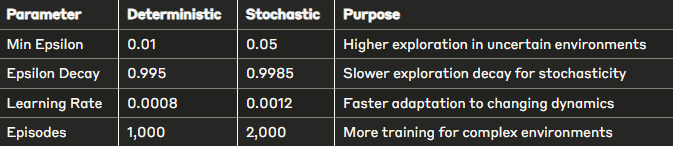

**Network Architecture**

* **Hidden Layers**: 128 nodes each for sufficient capacity
* **Gradient Clipping**: Max norm of 5.0 for training stability

In [ ]:
class TaxiDQN():
    discount_factor_g = 0.99
    replay_memory_size = 75000
    mini_batch_size = 64

    # Set up loss function
    loss_fn = nn.MSELoss()
    optimizer = None

    ACTIONS = ['S','N','E','W','P','D']

    def __init__(self, is_rainy=False, fickle_passenger=False):
        """
        Initialize TaxiDQN with stochastic environment options

        Args:
            is_rainy (bool): If True, movement actions have 80% success rate,
                             10% chance each of moving left/right of intended direction
            fickle_passenger (bool): If True, passenger has 30% chance of changing
                                   destinations after first movement away from pickup
        """
        self.is_rainy = is_rainy
        self.fickle_passenger = fickle_passenger
        self.is_stochastic = is_rainy or fickle_passenger

        # Adaptive hyperparameters based on environment complexity
        # Deterministic environment
        if not self.is_stochastic:
            self.epsilon_min = 0.01
            self.epsilon_decay = 0.995
            self.hidden_nodes = 128
            self.max_grad_norm = 5.0
            self.default_episodes = 1000
            self.learning_rate_a = 0.0008

        # Stochastic environments
        else:
            self.epsilon_min = 0.05
            self.epsilon_decay = 0.9985
            self.hidden_nodes = 128
            self.max_grad_norm = 5.0
            self.default_episodes = 2000
            self.learning_rate_a = 0.0012

        print(f"Environment: is_rainy={is_rainy}, fickle_passenger={fickle_passenger}")
        print(f"Hyperparameters: eps_min={self.epsilon_min}, eps_decay={self.epsilon_decay}, "
              f"hidden={self.hidden_nodes}, episodes={self.default_episodes}")

## **Deep Q-Network Training Pipeline**
### **Training Method (train)**
The core training method implements the complete DQN algorithm with experience replay, epsilon-greedy exploration, and neural network optimization.
### **Training Setup**

* **Environment Creation**: Taxi-v3 with specified stochastic parameters
* **Network Architecture**: Multi-layer DQN with configurable hidden nodes
* **Memory Buffer**: Experience replay with 75,000 transition capacity
* **Optimizer**: Adam optimizer with adaptive learning rate

### **Training Loop Components**
**Episode Execution**

* **State-Action Selection**: Epsilon-greedy policy with neural network Q-values
* **Experience Collection**: Store (state, action, next_state, reward, done) tuples
* **Environment Interaction**: Step-by-step learning through trial and error

**Learning Process**

* **Experience Replay**: Sample random mini-batches from memory buffer
* **Q-Network Updates**: Optimize network parameters every step when buffer is ready
* **Exploration Decay**: Gradual reduction of epsilon for exploitation focus

**Progress Monitoring**

* **Real-time Metrics**: Episode rewards, lengths, success rates every 100 episodes
* **Performance Tracking**: Moving averages for stable progress assessment

In [ ]:
def train(self, episodes=None):
        if episodes is None:
            episodes = self.default_episodes
        # Create environment with stochastic parameters
        env = gym.make('Taxi-v3', is_rainy=self.is_rainy, fickle_passenger=self.fickle_passenger)
        num_states = env.observation_space.n
        num_actions = env.action_space.n
        epsilon = 1.0
        memory = ReplayMemory(self.replay_memory_size)

        # Create DQN network
        policy_dqn = DQN(in_states=num_states, h1_nodes=self.hidden_nodes,
                        h2_nodes=self.hidden_nodes, out_actions=num_actions).to(DEVICE)
        # Initialize optimizer for gradient-based learning
        self.optimizer = torch.optim.Adam(policy_dqn.parameters(), lr=self.learning_rate_a)

        env_type = "Stochastic" if self.is_stochastic else "Deterministic"
        print(f'\nTraining {env_type} Policy:')
        print(f'Network: {num_states} -> {self.hidden_nodes} -> {self.hidden_nodes} -> {num_actions}')
        print(f'Device: {DEVICE}')
        rewards_per_episode = []
        epsilon_history = []
        episode_lengths = []
        successful_episodes = []

        for i in range(episodes):
            state, info = env.reset()
            terminated = False
            truncated = False
            episode_reward = 0
            episode_length = 0
            while not terminated and not truncated:
                episode_length += 1
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    with torch.no_grad():
                        state_tensor = self.state_to_dqn_input(state, num_states).unsqueeze(0).to(DEVICE)
                        q_values = policy_dqn(state_tensor)
                        action = q_values.argmax(dim=1).item()
                new_state, reward, terminated, truncated, info = env.step(action)
                episode_reward += reward
                memory.append((state, action, new_state, reward, terminated))
                state = new_state

                if len(memory) > self.mini_batch_size:
                    mini_batch = memory.sample(self.mini_batch_size)
                    self.optimize(mini_batch, policy_dqn)

            rewards_per_episode.append(episode_reward)
            episode_lengths.append(episode_length)
            successful_episodes.append(1 if episode_reward > 0 else 0)

            if epsilon > self.epsilon_min:
                epsilon *= self.epsilon_decay
            epsilon_history.append(epsilon)

            if (i + 1) % 100 == 0:
                avg_reward = np.mean(rewards_per_episode[-100:])
                avg_length = np.mean(episode_lengths[-100:])
                success_rate = np.mean(successful_episodes[-100:]) * 100
                print(f"Episode {i+1:4d}: Reward={avg_reward:6.2f}, Length={avg_length:5.1f}, "
                      f"Success={success_rate:5.1f}%, ε={epsilon:.3f}")
        env.close()
        # Save model
        model_name = f"taxi_dqn{'_stochastic' if self.is_stochastic else ''}.pt"
        torch.save(policy_dqn.state_dict(), model_name)
        self.plot_training_results(rewards_per_episode, epsilon_history, episode_lengths, successful_episodes)
        final_success_rate = np.mean(successful_episodes[-100:]) * 100
        final_avg_reward = np.mean(rewards_per_episode[-100:])
        print(f"\nTraining Complete!")
        print(f"Final 100-episode average: Reward={final_avg_reward:.2f}, Success Rate={final_success_rate:.1f}%")

## **DQN Training Results Visualization**
### **Plotting Method `plot_training_results`**
Comprehensive visualization of DQN training progress with 100-episode moving averages for clearer trend analysis (vs 1000-episode for tabular Q-Learning due to shorter training periods).

In [ ]:
def plot_training_results(self, rewards, epsilon_history, episode_lengths, successful_episodes):
        plt.figure(figsize=(15, 10))

        # Plot rewards with moving average
        plt.subplot(221)
        plt.plot(rewards, alpha=0.3, color='blue', label='Episode Reward')
        if len(rewards) >= 100:
            moving_avg = [np.mean(rewards[max(0, i-99):i+1]) for i in range(len(rewards))]
            plt.plot(moving_avg, color='red', linewidth=2, label='100-Episode Average')
        plt.xlabel('Episode')
        plt.ylabel('Total Reward')
        env_type = "Stochastic" if self.is_stochastic else "Deterministic"
        plt.title(f'Training Rewards - {env_type} Environment')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot success rate
        plt.subplot(222)
        if len(successful_episodes) >= 100:
            success_rate_ma = [np.mean(successful_episodes[max(0, i-99):i+1]) * 100
                             for i in range(len(successful_episodes))]
            plt.plot(success_rate_ma, color='green', linewidth=2)
        plt.xlabel('Episode')
        plt.ylabel('Success Rate (%)')
        plt.title('Success Rate (100-Episode Moving Average)')
        plt.grid(True, alpha=0.3)

        # Plot episode lengths
        plt.subplot(223)
        plt.plot(episode_lengths, alpha=0.3, color='purple', label='Episode Length')
        if len(episode_lengths) >= 100:
            moving_avg_length = [np.mean(episode_lengths[max(0, i-99):i+1])
                               for i in range(len(episode_lengths))]
            plt.plot(moving_avg_length, color='orange', linewidth=2, label='100-Episode Average')
        plt.xlabel('Episode')
        plt.ylabel('Steps to Complete')
        plt.title('Episode Lengths')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # Plot epsilon decay
        plt.subplot(224)
        plt.plot(epsilon_history, color='red')
        plt.xlabel('Episode')
        plt.ylabel('Epsilon (Exploration Rate)')
        plt.title('Exploration Rate Decay')
        plt.grid(True, alpha=0.3)

        plt.tight_layout()
        filename = f"taxi_dqn{'_stochastic' if self.is_stochastic else ''}_training.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()

## **DQN Neural Network Optimization**
### **Optimization Method `optimize`**
The heart of DQN learning - implements the Deep Q-Learning update rule using experience replay and neural network backpropagation.
### **Q-Learning Algorithm Implementation**
***Bellman Equation for DQN*** -->
`Q(s,a) ← r + γ·max(Q(s',a'))`

**Neural Network Training Process**

* **Batch Preparation**: Extract states, actions, rewards, next_states from mini-batch
* **Current Q-Values**: Forward pass through network for selected actions
* **Target Q-Values**: Compute targets using Bellman equation with no_grad()
* **Loss Calculation**: MSE between predicted and target Q-values
* **Backpropagation**: Update network weights using Adam optimizer

### **Key Differences from Tabular Q-Learning**

* **Function Approximation**: Neural network vs lookup table
* **Batch Updates**: Multiple experiences per update vs single experience
* **Gradient-Based**: Backpropagation vs direct table updates

In [ ]:
def optimize(self, mini_batch, policy_dqn):
        """Optimize the DQN with experience replay"""
        num_states = policy_dqn.fc1.in_features

        states = [t[0] for t in mini_batch]
        actions = torch.tensor([t[1] for t in mini_batch], dtype=torch.long, device=DEVICE)
        next_states = [t[2] for t in mini_batch]
        rewards = torch.tensor([t[3] for t in mini_batch], dtype=torch.float32, device=DEVICE)
        dones = torch.tensor([t[4] for t in mini_batch], dtype=torch.bool, device=DEVICE)

        state_batch = self.state_to_dqn_input(states, num_states).to(DEVICE)
        next_state_batch = self.state_to_dqn_input(next_states, num_states).to(DEVICE)

        pred_q_all = policy_dqn(state_batch)
        pred_q = pred_q_all.gather(1, actions.unsqueeze(1)).squeeze(1)

        with torch.no_grad():
            next_q_all = policy_dqn(next_state_batch)
            max_next_q, _ = next_q_all.max(dim=1)
            target_q = rewards + (~dones).float() * (self.discount_factor_g * max_next_q) #Bellman equation

        loss = self.loss_fn(pred_q, target_q) #Compute loss, how wrong are we from the predicted value?

        self.optimizer.zero_grad() # Backpropagation, clear old gradients
        loss.backward() # ∂loss/∂weight --> Compute new gradients, determines direction to move each weight to reduce error
        torch.nn.utils.clip_grad_norm_(policy_dqn.parameters(), max_norm=self.max_grad_norm) # Gradient clipping
        self.optimizer.step() # Update weights

## **State Conversion Method `state_to_dqn_input`**
Converts discrete integer states to one-hot encoded tensors suitable for neural network input

**Conversion Process**

* **Input**: Integer `state(s)` from Taxi environment (0-499)
* **Output**: One-hot encoded float `tensor(s)` for neural network
* **Flexibility**: Handles both single states and batches of states

In [ ]:
def state_to_dqn_input(self, states, num_states: int) -> torch.Tensor:
        """Convert integer state or list of states to one-hot float tensor."""
        if isinstance(states, (list, tuple, np.ndarray)):
            idx = torch.tensor(states, dtype=torch.long)
            one_hot = F.one_hot(idx, num_classes=num_states).float()
            return one_hot
        else:
            idx = torch.tensor([states], dtype=torch.long)
            one_hot = F.one_hot(idx, num_classes=num_states).float().squeeze(0)
            return one_hot

## **DQN Model Testing and Evaluation**
### **Testing Method `test`**
Evaluates the trained DQN policy using greedy action selection (no exploration) to assess true learned performance across multiple test episodes.

**Testing Pipeline**

* **Model Loading**: Restore trained neural network weights from disk
* **Evaluation Mode**: Set network to `eval()` mode (disables training features)
* **Greedy Policy**: Pure exploitation using `argmax(Q-values)` - no randomness
* **Performance Assessment**: Detailed statistics across test episodes

**Evaluation Metrics**

* **Success Rate**: Percentage of completed tasks
* **Average Rewards**: Overall policy performance
* **Episode Efficiency**: Steps required per successful completion
* **Performance Range**: Min/max rewards showing consistency

**Optional Visualization**

* **Render Mode**: Visual environment display for demonstration
* **Step-by-step Logging**: Action selection transparency for analysis

In [ ]:
def test(self, episodes=5, render=False):
        """Test the trained policy"""
        render_mode = 'human' if render else None
        env = gym.make('Taxi-v3', is_rainy=self.is_rainy, fickle_passenger=self.fickle_passenger, render_mode=render_mode)
        num_states = env.observation_space.n
        num_actions = env.action_space.n
        # Load appropriate model
        model_name = f"taxi_dqn{'_stochastic' if self.is_stochastic else ''}.pt"
        policy_dqn = DQN(in_states=num_states, h1_nodes=self.hidden_nodes, \
                        h2_nodes=self.hidden_nodes, out_actions=num_actions).to(DEVICE)
        if not os.path.exists(model_name):
            print(f"No trained model found ({model_name}). Please run training first.")
            return
        policy_dqn.load_state_dict(torch.load(model_name, map_location=DEVICE))
        policy_dqn.eval()
        env_type = "stochastic" if self.is_stochastic else "deterministic"
        print(f'\nTesting trained policy on {env_type} environment...')
        total_rewards = []
        total_steps = []
        successful_deliveries = 0
        for episode in range(episodes):
            state, info = env.reset()
            if render:
                env.render()
            terminated = False
            truncated = False
            episode_reward = 0
            steps = 0
            print(f"\nEpisode {episode + 1}:")
            while not terminated and not truncated and steps < 500:
                with torch.no_grad():
                    state_tensor = self.state_to_dqn_input(state, num_states).unsqueeze(0).to(DEVICE)
                    q_values = policy_dqn(state_tensor)
                    action = q_values.argmax(dim=1).item()
                # print(f"  Step {steps + 1}: Action {self.ACTIONS[action]}")
                if render:
                    env.render()
                state, reward, terminated, truncated, info = env.step(action)
                episode_reward += reward
                steps += 1
            total_rewards.append(episode_reward)
            total_steps.append(steps)
            if episode_reward > 0:
                successful_deliveries += 1
                print(f"  ✓ SUCCESS! Reward: {episode_reward}, Steps: {steps}")
            else:
                print(f"  ✗ Failed. Reward: {episode_reward}, Steps: {steps}")
        env.close()
        avg_reward = np.mean(total_rewards)
        avg_steps = np.mean(total_steps)
        success_rate = successful_deliveries / episodes * 100
        print(f"\n{'='*50}")
        print(f"TEST RESULTS ({env_type.upper()} ENVIRONMENT)")
        print(f"{'='*50}")
        print(f"Episodes:      {episodes}")
        print(f"Success Rate:  {success_rate:.1f}% ({successful_deliveries}/{episodes})")
        print(f"Avg Reward:    {avg_reward:.2f}")
        print(f"Avg Steps:     {avg_steps:.1f}")
        print(f"Reward Range:  {min(total_rewards):.1f} to {max(total_rewards):.1f}")

## **The TaxiDQN `__init__` method**

The `__init__` method for the TaxiDQN class sets up the initial configuration and hyperparameters for the deep Q-learning agent. It adapts its settings based on whether the environment is stochastic (unpredictable).

* `is_rainy` and `fickle_passenger`: These boolean parameters define the environment's complexity. If either is True, the environment is considered stochastic.

* `is_stochastic`: A flag automatically set to `True` if `is_rainy` or `fickle_passenger` is `True`.

### **Adaptive Hyperparameters**

The method assigns different values for key training parameters, like `epsilon_min`,` epsilon_decay`, `hidden_nodes`, and `learning_rate_a`, depending on whether the environment is stochastic.

**Deterministic Environment**

Uses a more aggressive `epsilon_decay` and a lower `epsilon_min` because the environment is stable and requires less exploration.

**Stochastic Environment**

Uses a slower `epsilon_decay` and a higher `epsilon_min` to ensure the agent continues to explore and adapt to the unpredictable changes.

### **Printed Output**

The method prints the chosen environment configuration and the resulting hyperparameters to the console, providing immediate feedback on how the agent is being set up.

In [ ]:
if __name__ == '__main__':
    # Choose one configuration to test
    print("Choose environment configuration:")
    print("1. Deterministic (original)")
    print("2. Rainy weather only")
    print("3. Fickle passenger only")
    print("4. Both rainy and fickle (hardest)")

    choice = input("Enter choice (1-4): ").strip()

    config_map = {
        '1': (False, False, "deterministic"),
        '2': (True, False, "rainy"),
        '3': (False, True, "fickle"),
        '4': (True, True, "rainy_and_fickle")
    }

    if choice not in config_map:
        print("Invalid choice, using deterministic environment")
        choice = '1'

    is_rainy, fickle_passenger, name = config_map[choice]

    print(f"\n{'='*60}")
    print(f"TRAINING {name.upper().replace('_', ' + ')} TAXI ENVIRONMENT")
    print(f"{'='*60}")

    taxi_agent = TaxiDQN(is_rainy=is_rainy, fickle_passenger=fickle_passenger)

    # Train the agent
    taxi_agent.train()

    # Test the trained agent
    print("\nWould you like to visualize the testing? (y/n): ", end="")
    show_render = input().strip().lower() == 'y'

    if show_render:
        print("Rendering enabled - you'll see a visual window!")
        taxi_agent.test(episodes=5, render=True)
    else:
        taxi_agent.test(episodes=5, render=False)